On prépare les données MNIST :

In [1]:
import numpy as np
from keras.datasets import mnist
from matplotlib import pyplot
import statistics as stat
from random import random
p=28*28
q=10*10
cl=2
label1=2
label2=7
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X=train_X[(train_y==label1) | (train_y==label2)]
train_y=train_y[(train_y==label1) | (train_y==label2)]
test_X=test_X[(test_y==label1) | (test_y==label2)]
test_y=test_y[(test_y==label1) | (test_y==label2)]
train_X[train_X<130]=0
train_X[train_X>=130]=1
test_X[test_X<130]=0
test_X[test_X>=130]=1
train_X1=train_X[0:int(((train_X.shape[0]+1)/2))]
train_X2=train_X[int(((train_X.shape[0]+1)/2)):int(train_X.shape[0]+1)]
test_X1=test_X[0:int(((test_X.shape[0]+1)/2))]
test_X2=test_X[int(((test_X.shape[0]+1)/2)):int(test_X.shape[0]+1)]
train_y1=train_y[0:int(((train_X.shape[0]+1)/2))]
train_y2=train_y[int(((train_X.shape[0]+1)/2)):int(train_X.shape[0]+1)]
test_y1=test_y[0:int(((test_X.shape[0]+1)/2))]
test_y2=test_y[int(((test_X.shape[0]+1)/2)):int(test_X.shape[0]+1)]
train_X1=train_X1.reshape((int(train_X1.shape[0]),p))
train_X2=train_X2.reshape((int(train_X2.shape[0]),p))
test_X1=test_X1.reshape((int(test_X1.shape[0]),p))
test_X2=test_X2.reshape((int(test_X2.shape[0]),p))

11501568/11490434 [==============================] - 0s 0us/step


On créer les fonctions permettant de faire l'échantillonage de Gibbs et de calculer le gradient pour préparer l'algorithme de montée du gradient :

In [ ]:
def sigm(x):
  return 1/(1+np.exp(-x))

def density_cond_v(v,a,b,w):
  return sigm(b+v.dot(w))

def density_cond_h(h,a,b,w):
  return sigm(a+w.dot(h))

def grad(k,v,a,b,w):
  V=np.zeros((p,k+1))
  V[:,0]=v
  H=np.zeros((q,k+1))
  H[:,0]=density_cond_v(v,a,b,w)>np.random.rand(q)
  i=1
  while i<(k+1):
    V[:,i]=density_cond_h(H[:,i-1],a,b,w)>np.random.rand(p)
    H[:,i]=density_cond_v(V[:,i],a,b,w)>np.random.rand(q)
    i=i+1
  h_0=density_cond_v(V[:,0],a,b,w)>np.random.rand(q)
  A1=V[:,0]
  A2=V[:,k]
  B1=h_0
  B2=H[:,k]
  W1=V[:,0].reshape((p,1)).dot(h_0.reshape((1,q)))
  W2=V[:,k].reshape((p,1)).dot(H[:,k].reshape((1,q)))
  A=A1-A2
  B=B1-B2
  W=W1-W2
  W=W.reshape((p*q))
  gradient=np.concatenate((A,B,W))
  return gradient
grad(1,train_X1[3],np.random.rand(p),np.random.rand(q),1/1000*np.random.rand(p,q))

array([-1.,  0.,  0., ...,  0.,  0.,  0.])

On programme maintenant la montée du gradient :

In [ ]:
def mont_grad(I,k,a,b,w,eps,delta):
  indice=np.random.randint(train_X1.shape[0])
  v=train_X1[indice]
  i=0
  while (np.linalg.norm(grad(k,v,a,b,w))>eps):
    a=a+delta*grad(k,v,a,b,w)[0:p]
    b=b+delta*grad(k,v,a,b,w)[p:p+q]
    w=w+delta*grad(k,v,a,b,w)[p+q:].reshape((p,q))
    indice=np.random.randint(train_X1.shape[0])
    v=train_X1[indice]
    if (i%10==0):
      print("Norme du gradient =",np.linalg.norm(grad(k,v,a,b,w)))
      test=density_cond_v(v,a,b,w)
      resultat=density_cond_h(test,a,b,w)
      resultat=resultat.reshape(28,28)>np.random.rand(28,28)
      print("Erreur de reconstruction =",np.linalg.norm(resultat-v.reshape((28,28))))
      print(int(i/100),"%")
    i=i+1
    if i==I:
      break
  return [a,b,w.reshape((p,q))]
(a1,b1,w1)=mont_grad(5000,1,np.random.normal(scale=0.01,size=p),np.random.normal(scale=0.01,size=q),np.random.normal(scale=0.01,size=(p,q)),1,1/10)
(a1,b1,w1)=mont_grad(3000,1,a1,b1,w1,1,1/100)
(a1,b1,w1)=mont_grad(2000,1,a1,b1,w1,1,1/1000)
(a1,b1,w1)=mont_grad(1500,1,a1,b1,w1,1,1/10000)
(a1,b1,w1)=mont_grad(1000,1,a1,b1,w1,1,1/100000)

Norme du gradient = 129.2632971883357
Erreur de reconstruction = 1551.1966348596816
0 %
Norme du gradient = 65.83312236253116
Erreur de reconstruction = 2252.1345430502147
0 %
Norme du gradient = 62.0644825967316
Erreur de reconstruction = 1508.6331562046487
0 %
Norme du gradient = 53.36665625650534
Erreur de reconstruction = 1838.8624200847653
0 %
Norme du gradient = 53.376024580330075
Erreur de reconstruction = 2163.767778667572
0 %
Norme du gradient = 49.98999899979995
Erreur de reconstruction = 1612.793539173567
0 %
Norme du gradient = 56.1159513863928
Erreur de reconstruction = 1942.0393919794726
0 %
Norme du gradient = 50.774009099144415
Erreur de reconstruction = 1766.7068234429842
0 %
Norme du gradient = 43.81780460041329
Erreur de reconstruction = 1325.054715851387
0 %
Norme du gradient = 52.172789842982326
Erreur de reconstruction = 1508.6159219629096
0 %
Norme du gradient = 46.71188285650665
Erreur de reconstruction = 1766.7221060483735
1 %
Norme du gradient = 44.89988864128

On affiche les quelques images choisit au hasard dans le test que l'on passe dans notre machine de Boltzmann restreinte pour observer quelques reconstructions d'images :

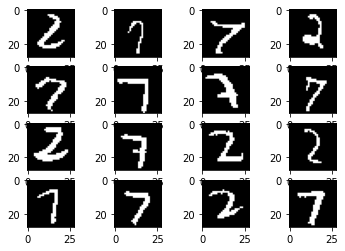

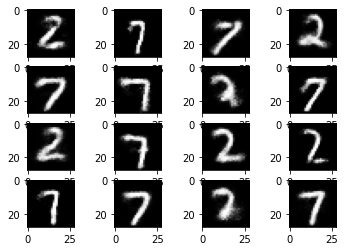

In [ ]:
v=np.random.randint(test_X1.shape[0],size=16)
figure, axis = pyplot.subplots(4, 4)
axis[0, 0].imshow(test_X1[v[0]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[1, 0].imshow(test_X1[v[1]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[2, 0].imshow(test_X1[v[2]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[3, 0].imshow(test_X1[v[3]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[0, 1].imshow(test_X1[v[4]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[1, 1].imshow(test_X1[v[5]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[2, 1].imshow(test_X1[v[6]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[3, 1].imshow(test_X1[v[7]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[0, 2].imshow(test_X1[v[8]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[1, 2].imshow(test_X1[v[9]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[2, 2].imshow(test_X1[v[10]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[3, 2].imshow(test_X1[v[11]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[0, 3].imshow(test_X1[v[12]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[1, 3].imshow(test_X1[v[13]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[2, 3].imshow(test_X1[v[14]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[3, 3].imshow(test_X1[v[15]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
pyplot.show()  
figure, axis = pyplot.subplots(4, 4)
axis[0, 0].imshow(density_cond_h(density_cond_v(test_X1[v[0]],a1,b1,w1),a1,b1,w1).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[1, 0].imshow(density_cond_h(density_cond_v(test_X1[v[1]],a1,b1,w1),a1,b1,w1).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[2, 0].imshow(density_cond_h(density_cond_v(test_X1[v[2]],a1,b1,w1),a1,b1,w1).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[3, 0].imshow(density_cond_h(density_cond_v(test_X1[v[3]],a1,b1,w1),a1,b1,w1).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[0, 1].imshow(density_cond_h(density_cond_v(test_X1[v[4]],a1,b1,w1),a1,b1,w1).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[1, 1].imshow(density_cond_h(density_cond_v(test_X1[v[5]],a1,b1,w1),a1,b1,w1).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[2, 1].imshow(density_cond_h(density_cond_v(test_X1[v[6]],a1,b1,w1),a1,b1,w1).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[3, 1].imshow(density_cond_h(density_cond_v(test_X1[v[7]],a1,b1,w1),a1,b1,w1).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[0, 2].imshow(density_cond_h(density_cond_v(test_X1[v[8]],a1,b1,w1),a1,b1,w1).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[1, 2].imshow(density_cond_h(density_cond_v(test_X1[v[9]],a1,b1,w1),a1,b1,w1).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[2, 2].imshow(density_cond_h(density_cond_v(test_X1[v[10]],a1,b1,w1),a1,b1,w1).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[3, 2].imshow(density_cond_h(density_cond_v(test_X1[v[11]],a1,b1,w1),a1,b1,w1).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[0, 3].imshow(density_cond_h(density_cond_v(test_X1[v[12]],a1,b1,w1),a1,b1,w1).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[1, 3].imshow(density_cond_h(density_cond_v(test_X1[v[13]],a1,b1,w1),a1,b1,w1).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[2, 3].imshow(density_cond_h(density_cond_v(test_X1[v[14]],a1,b1,w1),a1,b1,w1).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[3, 3].imshow(density_cond_h(density_cond_v(test_X1[v[15]],a1,b1,w1),a1,b1,w1).reshape(28,28), cmap=pyplot.get_cmap('gray'))
pyplot.show()

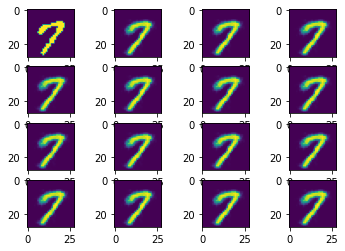

784

In [ ]:
i=1
k=100
V=np.zeros((28*28,k))
V[:,0]=train_X1[1]
while i<k:
  V[:,i]=density_cond_h(density_cond_v(V[:,i-1],a1,b1,w1),a1,b1,w1)
  i=i+1
figure, axis = pyplot.subplots(4, 4)
axis[0, 0].imshow(V[:,0].reshape(28,28))
axis[1, 0].imshow(V[:,1].reshape(28,28))
axis[2, 0].imshow(V[:,2].reshape(28,28))
axis[3, 0].imshow(V[:,3].reshape(28,28))
axis[0, 1].imshow(V[:,4].reshape(28,28))
axis[1, 1].imshow(V[:,5].reshape(28,28))
axis[2, 1].imshow(V[:,6].reshape(28,28))
axis[3, 1].imshow(V[:,7].reshape(28,28))
axis[0, 2].imshow(V[:,8].reshape(28,28))
axis[1, 2].imshow(V[:,9].reshape(28,28))
axis[2, 2].imshow(V[:,10].reshape(28,28))
axis[3, 2].imshow(V[:,11].reshape(28,28))
axis[0, 3].imshow(V[:,12].reshape(28,28))
axis[1, 3].imshow(V[:,13].reshape(28,28))
axis[2, 3].imshow(V[:,14].reshape(28,28))
axis[3, 3].imshow(V[:,99].reshape(28,28))
pyplot.show()
test_y1[1:30]
sum(V[:,9]!=V[:,99])

On fixe quelques variables de la couche cachée et on affiche les poids de la matrice W correspondants :

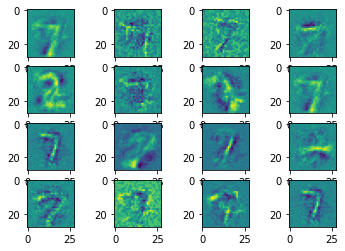

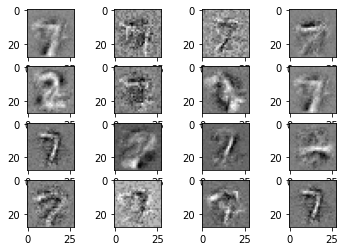

In [ ]:
poids=(a1,b1,w1)
v=np.random.randint(100,size=16)
figure, axis = pyplot.subplots(4, 4)
axis[0, 0].imshow(w1[:,v[0]].reshape(28,28))
axis[1, 0].imshow(w1[:,v[1]].reshape(28,28))
axis[2, 0].imshow(w1[:,v[2]].reshape(28,28))
axis[3, 0].imshow(w1[:,v[3]].reshape(28,28))
axis[0, 1].imshow(w1[:,v[4]].reshape(28,28))
axis[1, 1].imshow(w1[:,v[5]].reshape(28,28))
axis[2, 1].imshow(w1[:,v[6]].reshape(28,28))
axis[3, 1].imshow(w1[:,v[7]].reshape(28,28))
axis[0, 2].imshow(w1[:,v[8]].reshape(28,28))
axis[1, 2].imshow(w1[:,v[9]].reshape(28,28))
axis[2, 2].imshow(w1[:,v[10]].reshape(28,28))
axis[3, 2].imshow(w1[:,v[11]].reshape(28,28))
axis[0, 3].imshow(w1[:,v[12]].reshape(28,28))
axis[1, 3].imshow(w1[:,v[13]].reshape(28,28))
axis[2, 3].imshow(w1[:,v[14]].reshape(28,28))
axis[3, 3].imshow(w1[:,v[15]].reshape(28,28))
pyplot.show()
figure, axis = pyplot.subplots(4, 4)
axis[0, 0].imshow(w1[:,v[0]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[1, 0].imshow(w1[:,v[1]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[2, 0].imshow(w1[:,v[2]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[3, 0].imshow(w1[:,v[3]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[0, 1].imshow(w1[:,v[4]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[1, 1].imshow(w1[:,v[5]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[2, 1].imshow(w1[:,v[6]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[3, 1].imshow(w1[:,v[7]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[0, 2].imshow(w1[:,v[8]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[1, 2].imshow(w1[:,v[9]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[2, 2].imshow(w1[:,v[10]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[3, 2].imshow(w1[:,v[11]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[0, 3].imshow(w1[:,v[12]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[1, 3].imshow(w1[:,v[13]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[2, 3].imshow(w1[:,v[14]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[3, 3].imshow(w1[:,v[15]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
pyplot.show()

Classification :

On intègre le label au modèle :

In [ ]:
def sigm(x):
  return 1/(1+np.exp(-x))

def density_condh_vy(v,y,a,b,c,w,u):
  return sigm(b+u.dot(y)+np.transpose(w).dot(v))

def density_condv_h(h,a,b,c,w,u):
  return sigm(a+w.dot(h))

def density_condy_h(h,a,b,c,w,u):
  return np.exp(c+h.dot(u))/np.sum(np.exp(c+h.dot(u)))

def grad_class(k,v,y,a,b,c,w,u):
  V=np.zeros((p,k+1))
  V[:,0]=v
  Y=np.zeros((cl,k+1))
  Y[:,0]=y
  H=np.zeros((q,k+1))
  H[:,0]=density_condh_vy(v,y,a,b,c,w,u)>np.random.rand(q)
  i=1
  while i<(k+1):
    V[:,i]=density_condv_h(H[:,i-1],a,b,c,w,u)>np.random.rand(p)
    Y[:,i]=density_condy_h(H[:,i-1],a,b,c,w,u)>np.random.rand(cl)
    H[:,i]=density_condh_vy(V[:,i],Y[:,i],a,b,c,w,u)>np.random.rand(q)
    i=i+1
  h_0=density_condh_vy(V[:,0],Y[:,0],a,b,c,w,u)>np.random.rand(q)
  A1=V[:,0]
  A2=V[:,k]
  B1=h_0
  B2=H[:,k]
  C1=Y[:,0]
  C2=Y[:,k]
  W1=V[:,0].reshape((p,1)).dot(h_0.reshape((1,q)))
  W2=V[:,k].reshape((p,1)).dot(H[:,k].reshape((1,q)))
  U1=h_0.reshape((q,1)).dot(Y[:,0].reshape((1,cl)))
  U2=H[:,k].reshape((q,1)).dot(Y[:,k].reshape((1,cl)))
  A=A1-A2
  B=B1-B2
  C=C1-C2
  W=W1-W2
  W=W.reshape((p*q))
  U=U1-U2
  U=U.reshape((q*cl))
  gradient=np.concatenate((A,B,C,W,U))
  return gradient
grad_class(1,train_X1[3],np.array([1,0]),np.random.normal(scale=0.01,size=p),np.random.normal(scale=0.01,size=q),np.random.normal(scale=0.01,size=cl),np.random.normal(scale=0.01,size=(p,q)),np.random.normal(scale=0.01,size=(q,cl)))

array([ 0.,  0., -1., ..., -1.,  1., -1.])

On adapte la montée de gradient :

In [ ]:
train_y1_indicatrice=np.zeros((train_X1.shape[0],2))
i=0
while i<train_X1.shape[0]:
  if train_y1[i]==label1:
    train_y1_indicatrice[i,0]=1
    train_y1_indicatrice[i,1]=0
  else:
    train_y1_indicatrice[i,0]=0
    train_y1_indicatrice[i,1]=1
  i=i+1
test_y1_indicatrice=np.zeros((test_X1.shape[0],2))
i=0
while i<test_X1.shape[0]:
  if test_y1[i]==label1:
    test_y1_indicatrice[i,0]=1
    test_y1_indicatrice[i,1]=0
  else:
    test_y1_indicatrice[i,0]=0
    test_y1_indicatrice[i,1]=1
  i=i+1

In [ ]:
def mont_grad_class(I,k,a,b,c,w,u,eps,delta):
  indice=np.random.randint(train_X1.shape[0])
  v=train_X1[indice]
  y=train_y1_indicatrice[indice]
  i=0
  while (np.linalg.norm(grad_class(k,v,y,a,b,c,w,u))>eps):
    a=a+delta*grad_class(k,v,y,a,b,c,w,u)[0:p]
    b=b+delta*grad_class(k,v,y,a,b,c,w,u)[p:p+q]
    c=c+delta*grad_class(k,v,y,a,b,c,w,u)[p+q:p+q+cl]
    w=w+delta*grad_class(k,v,y,a,b,c,w,u)[p+q+cl:p+q+cl+p*q].reshape((p,q))
    u=u+delta*grad_class(k,v,y,a,b,c,w,u)[p+q+cl+p*q:].reshape((q,cl))
    indice=np.random.randint(train_X1.shape[0])
    v=train_X1[indice]
    y=train_y1_indicatrice[indice]
    if (i%10==0):
      print("Norme du gradient =",np.linalg.norm(grad_class(k,v,y,a,b,c,w,u)))
      test=density_condh_vy(v,y,a,b,c,w,u)
      resultat=density_condv_h(test,a,b,c,w,u)
      resultat=resultat.reshape(28,28)>np.random.rand(28,28)
      print("Erreur de reconstruction =",np.linalg.norm(resultat-v.reshape((28,28))))
      print(int(i/100),"%")
    i=i+1
    if i==I:
      break
  return [a,b,c,w.reshape((p,q)),u.reshape((q,cl))]
(a,b,c,w,u)=mont_grad_class(5000,1,np.random.normal(scale=0.01,size=p),np.random.normal(scale=0.01,size=q),np.random.normal(scale=0.01,size=cl),np.random.normal(scale=0.01,size=(p,q)),np.random.normal(scale=0.01,size=(q,cl)),1,1/10)
(a,b,c,w,u)=mont_grad_class(3000,1,a,b,c,w,u,1,1/100)
(a,b,c,w,u)=mont_grad_class(2000,1,a,b,c,w,u,1,1/1000)
(a,b,c,w,u)=mont_grad_class(1500,1,a,b,c,w,u,1,1/10000)
(a,b,c,w,u)=mont_grad_class(1000,1,a,b,c,w,u,1,1/100000)

Norme du gradient = 102.86398786747479
Erreur de reconstruction = 1508.6878404759548
0 %
Norme du gradient = 64.07807737440318
Erreur de reconstruction = 1196.0940598464654
0 %
Norme du gradient = 64.41273166075166
Erreur de reconstruction = 2133.497129128605
0 %
Norme du gradient = 49.8998997994986
Erreur de reconstruction = 1856.456570997555
0 %
Norme du gradient = 33.645207682521445
Erreur de reconstruction = 1785.0456576793772
0 %
Norme du gradient = 57.39337940912697
Erreur de reconstruction = 1803.1339384527153
0 %
Norme du gradient = 47.21228653645151
Erreur de reconstruction = 1975.2399854194932
0 %
Norme du gradient = 46.17358552246078
Erreur de reconstruction = 1419.7992815887744
0 %
Norme du gradient = 51.96152422706632
Erreur de reconstruction = 2102.7952824752106
0 %
Norme du gradient = 46.151923036857305
Erreur de reconstruction = 1958.7092688809128
0 %
Norme du gradient = 38.781438859330635
Erreur de reconstruction = 1486.9307314061405
1 %
Norme du gradient = 30.91924966

On réaffiche quelques images et poids pour notre machine classifiante:

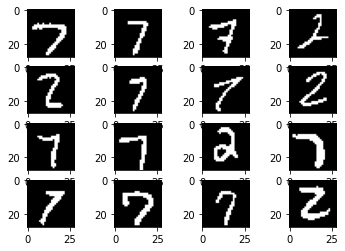

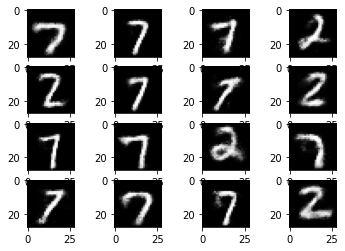

In [ ]:
poid_class=(a,b,c,w,u)
v=np.random.randint(test_X1.shape[0],size=16)
figure, axis = pyplot.subplots(4, 4)
axis[0, 0].imshow(test_X1[v[0]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[1, 0].imshow(test_X1[v[1]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[2, 0].imshow(test_X1[v[2]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[3, 0].imshow(test_X1[v[3]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[0, 1].imshow(test_X1[v[4]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[1, 1].imshow(test_X1[v[5]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[2, 1].imshow(test_X1[v[6]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[3, 1].imshow(test_X1[v[7]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[0, 2].imshow(test_X1[v[8]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[1, 2].imshow(test_X1[v[9]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[2, 2].imshow(test_X1[v[10]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[3, 2].imshow(test_X1[v[11]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[0, 3].imshow(test_X1[v[12]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[1, 3].imshow(test_X1[v[13]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[2, 3].imshow(test_X1[v[14]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[3, 3].imshow(test_X1[v[15]].reshape(28,28), cmap=pyplot.get_cmap('gray'))  
pyplot.show()
figure, axis = pyplot.subplots(4, 4)
axis[0, 0].imshow(density_condv_h(density_condh_vy(test_X1[v[0]],test_y1_indicatrice[v[0]],a,b,c,w,u),a,b,c,w,u).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[1, 0].imshow(density_condv_h(density_condh_vy(test_X1[v[1]],test_y1_indicatrice[v[1]],a,b,c,w,u),a,b,c,w,u).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[2, 0].imshow(density_condv_h(density_condh_vy(test_X1[v[2]],test_y1_indicatrice[v[2]],a,b,c,w,u),a,b,c,w,u).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[3, 0].imshow(density_condv_h(density_condh_vy(test_X1[v[3]],test_y1_indicatrice[v[3]],a,b,c,w,u),a,b,c,w,u).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[0, 1].imshow(density_condv_h(density_condh_vy(test_X1[v[4]],test_y1_indicatrice[v[4]],a,b,c,w,u),a,b,c,w,u).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[1, 1].imshow(density_condv_h(density_condh_vy(test_X1[v[5]],test_y1_indicatrice[v[5]],a,b,c,w,u),a,b,c,w,u).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[2, 1].imshow(density_condv_h(density_condh_vy(test_X1[v[6]],test_y1_indicatrice[v[6]],a,b,c,w,u),a,b,c,w,u).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[3, 1].imshow(density_condv_h(density_condh_vy(test_X1[v[7]],test_y1_indicatrice[v[7]],a,b,c,w,u),a,b,c,w,u).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[0, 2].imshow(density_condv_h(density_condh_vy(test_X1[v[8]],test_y1_indicatrice[v[8]],a,b,c,w,u),a,b,c,w,u).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[1, 2].imshow(density_condv_h(density_condh_vy(test_X1[v[9]],test_y1_indicatrice[v[9]],a,b,c,w,u),a,b,c,w,u).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[2, 2].imshow(density_condv_h(density_condh_vy(test_X1[v[10]],test_y1_indicatrice[v[10]],a,b,c,w,u),a,b,c,w,u).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[3, 2].imshow(density_condv_h(density_condh_vy(test_X1[v[11]],test_y1_indicatrice[v[11]],a,b,c,w,u),a,b,c,w,u).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[0, 3].imshow(density_condv_h(density_condh_vy(test_X1[v[12]],test_y1_indicatrice[v[12]],a,b,c,w,u),a,b,c,w,u).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[1, 3].imshow(density_condv_h(density_condh_vy(test_X1[v[13]],test_y1_indicatrice[v[13]],a,b,c,w,u),a,b,c,w,u).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[2, 3].imshow(density_condv_h(density_condh_vy(test_X1[v[14]],test_y1_indicatrice[v[14]],a,b,c,w,u),a,b,c,w,u).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[3, 3].imshow(density_condv_h(density_condh_vy(test_X1[v[15]],test_y1_indicatrice[v[15]],a,b,c,w,u),a,b,c,w,u).reshape(28,28), cmap=pyplot.get_cmap('gray')) 
pyplot.show()

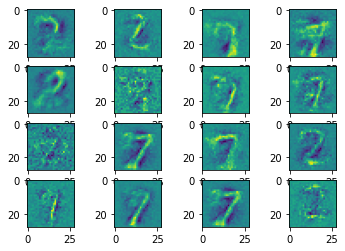

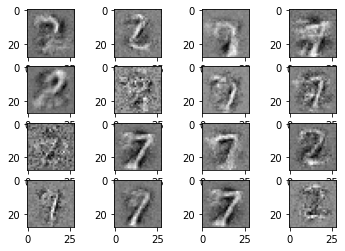

In [ ]:
v=np.random.randint(100,size=16)
figure, axis = pyplot.subplots(4, 4)
axis[0, 0].imshow(w[:,v[0]].reshape(28,28))
axis[1, 0].imshow(w[:,v[1]].reshape(28,28))
axis[2, 0].imshow(w[:,v[2]].reshape(28,28))
axis[3, 0].imshow(w[:,v[3]].reshape(28,28))
axis[0, 1].imshow(w[:,v[4]].reshape(28,28))
axis[1, 1].imshow(w[:,v[5]].reshape(28,28))
axis[2, 1].imshow(w[:,v[6]].reshape(28,28))
axis[3, 1].imshow(w[:,v[7]].reshape(28,28))
axis[0, 2].imshow(w[:,v[8]].reshape(28,28))
axis[1, 2].imshow(w[:,v[9]].reshape(28,28))
axis[2, 2].imshow(w[:,v[10]].reshape(28,28))
axis[3, 2].imshow(w[:,v[11]].reshape(28,28))
axis[0, 3].imshow(w[:,v[12]].reshape(28,28))
axis[1, 3].imshow(w[:,v[13]].reshape(28,28))
axis[2, 3].imshow(w[:,v[14]].reshape(28,28))
axis[3, 3].imshow(w[:,v[15]].reshape(28,28))
pyplot.show()
figure, axis = pyplot.subplots(4, 4)
axis[0, 0].imshow(w[:,v[0]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[1, 0].imshow(w[:,v[1]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[2, 0].imshow(w[:,v[2]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[3, 0].imshow(w[:,v[3]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[0, 1].imshow(w[:,v[4]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[1, 1].imshow(w[:,v[5]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[2, 1].imshow(w[:,v[6]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[3, 1].imshow(w[:,v[7]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[0, 2].imshow(w[:,v[8]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[1, 2].imshow(w[:,v[9]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[2, 2].imshow(w[:,v[10]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[3, 2].imshow(w[:,v[11]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[0, 3].imshow(w[:,v[12]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[1, 3].imshow(w[:,v[13]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[2, 3].imshow(w[:,v[14]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[3, 3].imshow(w[:,v[15]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
pyplot.show()

On calcule la probabilité d'un label sachant une image et on calcule l'accuracy de notre machine :

In [ ]:
cl=2
def proby_v(v,a,b,c,w,u):
  i=0
  a.astype('float128')
  b.astype('float128')
  c.astype('float128')
  w.astype('float128')
  u.astype('float128')
  prob=np.zeros(cl,dtype='float128')
  while i<cl:
    prob[i]=np.exp(c[i])*np.prod(1+np.exp(b+u[:,i]+np.transpose(w).dot(v)))
    i=i+1
  return prob
def classif2_v(v,a,b,c,w,u):
  return (label2-label1)*np.argmax(proby_v(v,a,b,c,w,u))+label1

def classif10_v(v,a,b,c,w,u):
  return np.argmax(proby_v(v,a,b,c,w,u))

res_test=np.zeros(test_X1.shape[0])
i=0
while i<test_X1.shape[0]:
  res_test[i]=classif2_v(test_X1[i],a,b,c,w,u)
  i=i+1
res_train=np.zeros(train_X1.shape[0])
i=0
while i<train_X1.shape[0]:
  res_train[i]=classif2_v(train_X1[i],a,b,c,w,u)
  i=i+1
print("Accuracy sur le train =",100-sum(res_train!=train_y1)/train_X1.shape[0]*100,"%")
print("Accuracy sur le test =",100-sum(res_test!=test_y1)/test_X1.shape[0]*100,"%")

Accuracy sur le train = 98.05301047120419 %
Accuracy sur le test = 96.50485436893204 %


On remarque que pour deux labels uniquement on obtient une bonne accuracy. Nous allons essayer de voir ce qu'il se passe si on augmente le nombres de labels.
On garde donc les 10 chiffres donc 10 labels. 

In [ ]:
p=28*28
q=10*10
cl=10
(train_Xf, train_yf), (test_Xf, test_yf) = mnist.load_data()
train_yf_indicatrice=np.zeros((train_Xf.shape[0],cl))
train_Xf=train_Xf.reshape((int(train_Xf.shape[0]),p))
test_Xf=test_Xf.reshape((int(test_Xf.shape[0]),p))
train_Xf[train_Xf<130]=0
train_Xf[train_Xf>=130]=1
test_Xf[test_Xf<130]=0
test_Xf[test_Xf>=130]=1
i=0
while i<train_Xf.shape[0]:
  train_yf_indicatrice[i,int(train_yf[i])]=1
  i=i+1
test_yf_indicatrice=np.zeros((test_Xf.shape[0],10))
i=0
while i<test_Xf.shape[0]:
  test_yf_indicatrice[i,int(test_yf[i])]=1
  i=i+1

In [ ]:
def mont_grad_class10(I,k,a,b,c,w,u,eps,delta):
  indice=np.random.randint(train_X1.shape[0])
  v=train_Xf[indice]
  y=train_yf_indicatrice[indice]
  i=0
  while (np.linalg.norm(grad_class(k,v,y,a,b,c,w,u))>eps):
    a=a+delta*grad_class(k,v,y,a,b,c,w,u)[0:p]
    b=b+delta*grad_class(k,v,y,a,b,c,w,u)[p:p+q]
    c=c+delta*grad_class(k,v,y,a,b,c,w,u)[p+q:p+q+cl]
    w=w+delta*grad_class(k,v,y,a,b,c,w,u)[p+q+cl:p+q+cl+p*q].reshape((p,q))
    u=u+delta*grad_class(k,v,y,a,b,c,w,u)[p+q+cl+p*q:].reshape((q,cl))
    indice=np.random.randint(train_X1.shape[0])
    v=train_Xf[indice]
    y=train_yf_indicatrice[indice]
    if (i%10==0):
      print("Norme du gradient =",np.linalg.norm(grad_class(k,v,y,a,b,c,w,u)))
      test=density_condh_vy(v,y,a,b,c,w,u)
      resultat=density_condv_h(test,a,b,c,w,u)
      resultat=resultat.reshape(28,28)>np.random.rand(28,28)
      print("Erreur de reconstruction =",np.linalg.norm(resultat-v.reshape((28,28))))
      print(int(i/100),"%")
    i=i+1
    if i==I:
      break
  return [a,b,c,w.reshape((p,q)),u.reshape((q,cl))]
(af,bf,cf,wf,uf)=mont_grad_class10(5000,1,np.random.normal(scale=0.01,size=p),np.random.normal(scale=0.01,size=q),np.random.normal(scale=0.01,size=cl),np.random.normal(scale=0.01,size=(p,q)),np.random.normal(scale=0.01,size=(q,cl)),1,1/10)
(af,bf,cf,wf,uf)=mont_grad_class10(3000,1,af,bf,cf,wf,uf,1,1/100)
(af,bf,cf,wf,uf)=mont_grad_class10(2500,1,af,bf,cf,wf,uf,1,1/1000)
(af,bf,cf,wf,uf)=mont_grad_class10(1500,1,af,bf,cf,wf,uf,1,1/10000)
(af,bf,cf,wf,uf)=mont_grad_class10(1000,1,af,bf,cf,wf,uf,1,1/100000)

Norme du gradient = 134.6476884316994
Erreur de reconstruction = 1419.8918972935933
0 %
Norme du gradient = 63.74950980203691
Erreur de reconstruction = 1891.1893083454127
0 %
Norme du gradient = 60.332412515993425
Erreur de reconstruction = 1612.8034598177176
0 %
Norme du gradient = 55.09990925582364
Erreur de reconstruction = 1325.059998641571
0 %
Norme du gradient = 59.58187643906493
Erreur de reconstruction = 1249.2761904398883
0 %
Norme du gradient = 54.30469592954186
Erreur de reconstruction = 1691.5034732450301
0 %
Norme du gradient = 52.99056519796708
Erreur de reconstruction = 1958.7307114557632
0 %
Norme du gradient = 54.27706698044764
Erreur de reconstruction = 1373.2366875378766
0 %
Norme du gradient = 56.938563381947034
Erreur de reconstruction = 1838.8463774877987
0 %
Norme du gradient = 46.3033476111609
Erreur de reconstruction = 1592.4986656195351
0 %
Norme du gradient = 51.088159097779204
Erreur de reconstruction = 1300.269202896077
1 %
Norme du gradient = 52.497618993

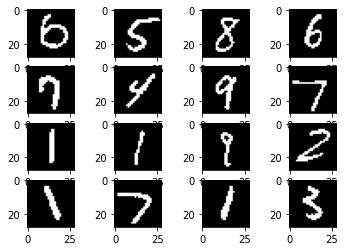

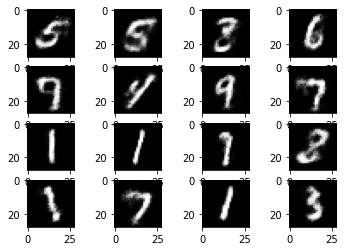

In [ ]:
poid_class=(af,bf,cf,wf,uf)
v=np.random.randint(test_X1.shape[0],size=16)
figure, axis = pyplot.subplots(4, 4)
axis[0, 0].imshow(test_Xf[v[0]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[1, 0].imshow(test_Xf[v[1]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[2, 0].imshow(test_Xf[v[2]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[3, 0].imshow(test_Xf[v[3]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[0, 1].imshow(test_Xf[v[4]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[1, 1].imshow(test_Xf[v[5]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[2, 1].imshow(test_Xf[v[6]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[3, 1].imshow(test_Xf[v[7]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[0, 2].imshow(test_Xf[v[8]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[1, 2].imshow(test_Xf[v[9]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[2, 2].imshow(test_Xf[v[10]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[3, 2].imshow(test_Xf[v[11]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[0, 3].imshow(test_Xf[v[12]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[1, 3].imshow(test_Xf[v[13]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[2, 3].imshow(test_Xf[v[14]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[3, 3].imshow(test_Xf[v[15]].reshape(28,28), cmap=pyplot.get_cmap('gray'))  
pyplot.show()
figure, axis = pyplot.subplots(4, 4)
axis[0, 0].imshow(density_condv_h(density_condh_vy(train_Xf[v[0]],train_yf_indicatrice[v[0]],af,bf,cf,wf,uf),af,bf,cf,wf,uf).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[1, 0].imshow(density_condv_h(density_condh_vy(test_Xf[v[1]],test_yf_indicatrice[v[1]],af,bf,cf,wf,uf),af,bf,cf,wf,uf).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[2, 0].imshow(density_condv_h(density_condh_vy(test_Xf[v[2]],test_yf_indicatrice[v[2]],af,bf,cf,wf,uf),af,bf,cf,wf,uf).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[3, 0].imshow(density_condv_h(density_condh_vy(test_Xf[v[3]],test_yf_indicatrice[v[3]],af,bf,cf,wf,uf),af,bf,cf,wf,uf).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[0, 1].imshow(density_condv_h(density_condh_vy(test_Xf[v[4]],test_yf_indicatrice[v[4]],af,bf,cf,wf,uf),af,bf,cf,wf,uf).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[1, 1].imshow(density_condv_h(density_condh_vy(test_Xf[v[5]],test_yf_indicatrice[v[5]],af,bf,cf,wf,uf),af,bf,cf,wf,uf).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[2, 1].imshow(density_condv_h(density_condh_vy(test_Xf[v[6]],test_yf_indicatrice[v[6]],af,bf,cf,wf,uf),af,bf,cf,wf,uf).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[3, 1].imshow(density_condv_h(density_condh_vy(test_Xf[v[7]],test_yf_indicatrice[v[7]],af,bf,cf,wf,uf),af,bf,cf,wf,uf).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[0, 2].imshow(density_condv_h(density_condh_vy(test_Xf[v[8]],test_yf_indicatrice[v[8]],af,bf,cf,wf,uf),af,bf,cf,wf,uf).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[1, 2].imshow(density_condv_h(density_condh_vy(test_Xf[v[9]],test_yf_indicatrice[v[9]],af,bf,cf,wf,uf),af,bf,cf,wf,uf).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[2, 2].imshow(density_condv_h(density_condh_vy(test_Xf[v[10]],test_yf_indicatrice[v[10]],af,bf,cf,wf,uf),af,bf,cf,wf,uf).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[3, 2].imshow(density_condv_h(density_condh_vy(test_Xf[v[11]],test_yf_indicatrice[v[11]],af,bf,cf,wf,uf),af,bf,cf,wf,uf).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[0, 3].imshow(density_condv_h(density_condh_vy(test_Xf[v[12]],test_yf_indicatrice[v[12]],af,bf,cf,wf,uf),af,bf,cf,wf,uf).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[1, 3].imshow(density_condv_h(density_condh_vy(test_Xf[v[13]],test_yf_indicatrice[v[13]],af,bf,cf,wf,uf),af,bf,cf,wf,uf).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[2, 3].imshow(density_condv_h(density_condh_vy(test_Xf[v[14]],test_yf_indicatrice[v[14]],af,bf,cf,wf,uf),af,bf,cf,wf,uf).reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[3, 3].imshow(density_condv_h(density_condh_vy(test_Xf[v[15]],test_yf_indicatrice[v[15]],af,bf,cf,wf,uf),af,bf,cf,wf,uf).reshape(28,28), cmap=pyplot.get_cmap('gray')) 
pyplot.show()

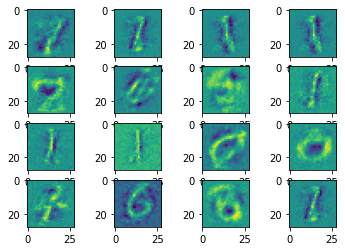

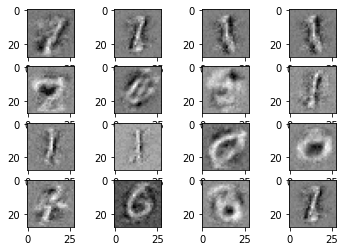

In [ ]:
v=np.random.randint(100,size=16)
figure, axis = pyplot.subplots(4, 4)
axis[0, 0].imshow(wf[:,v[0]].reshape(28,28))
axis[1, 0].imshow(wf[:,v[1]].reshape(28,28))
axis[2, 0].imshow(wf[:,v[2]].reshape(28,28))
axis[3, 0].imshow(wf[:,v[3]].reshape(28,28))
axis[0, 1].imshow(wf[:,v[4]].reshape(28,28))
axis[1, 1].imshow(wf[:,v[5]].reshape(28,28))
axis[2, 1].imshow(wf[:,v[6]].reshape(28,28))
axis[3, 1].imshow(wf[:,v[7]].reshape(28,28))
axis[0, 2].imshow(wf[:,v[8]].reshape(28,28))
axis[1, 2].imshow(wf[:,v[9]].reshape(28,28))
axis[2, 2].imshow(wf[:,v[10]].reshape(28,28))
axis[3, 2].imshow(wf[:,v[11]].reshape(28,28))
axis[0, 3].imshow(wf[:,v[12]].reshape(28,28))
axis[1, 3].imshow(wf[:,v[13]].reshape(28,28))
axis[2, 3].imshow(wf[:,v[14]].reshape(28,28))
axis[3, 3].imshow(wf[:,v[15]].reshape(28,28))
pyplot.show()
figure, axis = pyplot.subplots(4, 4)
axis[0, 0].imshow(wf[:,v[0]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[1, 0].imshow(wf[:,v[1]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[2, 0].imshow(wf[:,v[2]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[3, 0].imshow(wf[:,v[3]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[0, 1].imshow(wf[:,v[4]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[1, 1].imshow(wf[:,v[5]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[2, 1].imshow(wf[:,v[6]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[3, 1].imshow(wf[:,v[7]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[0, 2].imshow(wf[:,v[8]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[1, 2].imshow(wf[:,v[9]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[2, 2].imshow(wf[:,v[10]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[3, 2].imshow(wf[:,v[11]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[0, 3].imshow(wf[:,v[12]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[1, 3].imshow(wf[:,v[13]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[2, 3].imshow(wf[:,v[14]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
axis[3, 3].imshow(wf[:,v[15]].reshape(28,28), cmap=pyplot.get_cmap('gray'))
pyplot.show()

In [ ]:
res_testf=np.zeros(test_Xf.shape[0])
i=0
while i<test_Xf.shape[0]:
  res_testf[i]=classif10_v(test_Xf[i],af,bf,cf,wf,uf)
  i=i+1
res_trainf=np.zeros(train_Xf.shape[0])
i=0
while i<train_Xf.shape[0]:
  res_trainf[i]=classif10_v(train_Xf[i],af,bf,cf,wf,uf)
  i=i+1
print("Accuracy sur le train =",100-sum(res_trainf!=train_yf)/train_Xf.shape[0]*100,"%")
print("Accuracy sur le test =",100-sum(res_testf!=test_yf)/test_Xf.shape[0]*100,"%")

Accuracy sur le train = 83.945 %
Accuracy sur le test = 84.22 %


On remarque une diminution de l'accuracy quand on augmente le nombres de classes.